In [1]:
import random
import pandas as pd
from tqdm import tqdm
import argparse
import numpy as np
from data_loader import load_data
from utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F

# 날짜로 필터링
def date_filter(df, start_date, end_date):
    time_position = 1  # Adjust this to match the position of HHMM in your column names
    filtered_columns = [col for col in df.columns if start_date <= col[time_position:time_position + 4] <= end_date]
    filtered_df = df[filtered_columns]
    return filtered_df

# 시간으로 필터링
# start_time = '0900'
# end_time = '1800'
def time_filter(df, start_time, end_time):
    time_position = 5  # Adjust this to match the position of HHMM in your column names
    filtered_columns = [col for col in df.columns if start_time <= col[time_position:time_position + 4] <= end_time]
    filtered_df = df[filtered_columns]
    return filtered_df

/home/sungwon/anaconda3/envs/gnn2mlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [27]:
datapath = './../SeoulData/urban-core_v2.csv'
df = pd.read_csv(datapath)

if 'core' in datapath :
    speed_data = df.drop(columns=['Link_ID_1'	,'Link_ID_2',	'Center_Point_1',	'Center_Point_2',	'Limit'	,'Length',	'Direction'])
else :
    speed_data = df.drop(columns=['Link_ID_1','Start_1','Start_2','End_1','End_2','Limit','-'])

filtered_df = time_filter(speed_data, '0900', '1800')
filtered_df.head()

,704010900,704010905,704010910,704010915,704010920,704010925,704010930,704010935,704010940,704010945,...,104301715,104301720,104301725,104301730,104301735,104301740,104301745,104301750,104301755,104301800
0,51.12,50.01,47.53,47.77,47.40,50.98,48.33,46.68,50.11,48.91,...,32.01,33.81,32.83,31.38,32.58,33.32,36.76,39.55,42.13,40.48
1,50.69,50.16,50.40,52.73,51.69,50.87,50.10,52.51,54.66,50.59,...,46.12,50.22,45.43,49.39,46.66,45.62,38.27,45.52,47.66,47.09
2,43.25,44.17,44.58,46.42,31.31,41.25,33.56,25.08,33.52,31.68,...,35.39,33.30,33.62,31.89,36.83,36.25,31.40,36.42,29.78,35.04
3,35.16,43.00,43.00,33.41,35.21,32.45,35.00,45.92,33.10,34.34,...,29.98,31.98,29.04,31.85,39.85,40.69,29.76,42.69,30.62,28.81
4,48.35,47.25,63.00,47.01,52.27,43.24,51.61,63.00,50.48,49.77,...,34.03,39.60,34.45,35.68,33.36,32.16,33.60,33.50,32.51,32.91


# Prediction

In [40]:
filtered_df = date_filter(speed_data, '0423', '0430')
filtered_np = filtered_df.to_numpy()

model = 'LSTM_correlation_multi_attention'
time_window = 5
device = 2
device = torch.device("cuda:" + str(device)
                          if torch.cuda.is_available() else "cpu")
num_point = len(df)
lstm_n_layers = 2

x = filtered_np[:,time_window:]
col_names = filtered_df.columns[time_window:]
time = []

for col_name in col_names :
    time.append(col_name[1:])
    
if model == 'LSTM':
    from LSTM import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation':
    from LSTM_correlation import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_v2':
    from LSTM_correlation_v2 import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_v3':
    from LSTM_correlation_v3 import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_attention':
    from LSTM_correlation_attention import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_multi_attention':
    from LSTM_correlation_attention import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
    
if 'core' in datapath :
    lstm_model = torch.load(f'./model_state_dict/core/{model}.pt').to(device)
else :
    lstm_model = torch.load(f'./model_state_dict/mix/{model}.pt').to(device)

# test tasks sampling
available_starting_points = list(range(filtered_np.shape[1]))[:-time_window]
sampled_starting_points = available_starting_points[:time_window]

valid_tasks = []
for start_point in available_starting_points:
    sample_col_idx = [start_point]
    for i in range(time_window-1):
        sample_col_idx.append(start_point+(i+1))
    y_idx = sample_col_idx[-1]+1
    valid_task = filtered_np[:,sample_col_idx]
    y = filtered_np[:,y_idx]
    valid_tasks.append((valid_task, y))

pred_xs = []
for task in tqdm(valid_tasks):
    sequence = torch.Tensor(task[0]).to(device)
    if model == 'LSTM_correlation_v3':
        pred_x, spatial_loss = lstm_model(sequence)
    else:
        pred_x = lstm_model(sequence).tolist()
    pred_xs.append(pred_x)

pred_x1 = torch.Tensor(pred_xs).squeeze(-1).T


100%|██████████| 2299/2299 [00:03<00:00, 699.63it/s]


In [41]:
# filtered_df = date_filter(speed_data, '0423', '0430')
# filtered_np = filtered_df.to_numpy()

model = 'LSTM'
time_window = 5
device = 2
device = torch.device("cuda:" + str(device)
                          if torch.cuda.is_available() else "cpu")
num_point = len(df)
lstm_n_layers = 2

x = filtered_np[:,time_window:]
col_names = filtered_df.columns[time_window:]
time = []

for col_name in col_names :
    time.append(col_name[1:])
    
if model == 'LSTM':
    from LSTM import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation':
    from LSTM_correlation import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_v2':
    from LSTM_correlation_v2 import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_v3':
    from LSTM_correlation_v3 import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_attention':
    from LSTM_correlation_attention import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
elif model == 'LSTM_correlation_multi_attention':
    from LSTM_correlation_attention import LSTM
    lstm_model = LSTM(time_window, num_point,
                        num_layers=lstm_n_layers, output_size=1).to(device)
    
if 'core' in datapath :
    lstm_model = torch.load(f'./model_state_dict/core/{model}.pt').to(device)
else :
    lstm_model = torch.load(f'./model_state_dict/mix/{model}.pt').to(device)

# test tasks sampling
available_starting_points = list(range(filtered_np.shape[1]))[:-time_window]
sampled_starting_points = available_starting_points[:time_window]

valid_tasks = []
for start_point in available_starting_points:
    sample_col_idx = [start_point]
    for i in range(time_window-1):
        sample_col_idx.append(start_point+(i+1))
    y_idx = sample_col_idx[-1]+1
    valid_task = filtered_np[:,sample_col_idx]
    y = filtered_np[:,y_idx]
    valid_tasks.append((valid_task, y))

pred_xs = []
for task in tqdm(valid_tasks):
    sequence = torch.Tensor(task[0]).to(device)
    if model == 'LSTM_correlation_v3':
        pred_x, spatial_loss = lstm_model(sequence)
    else:
        pred_x = lstm_model(sequence).tolist()
    pred_xs.append(pred_x)

pred_x2 = torch.Tensor(pred_xs).squeeze(-1).T


100%|██████████| 2299/2299 [00:02<00:00, 965.21it/s] 


# Draw a figure

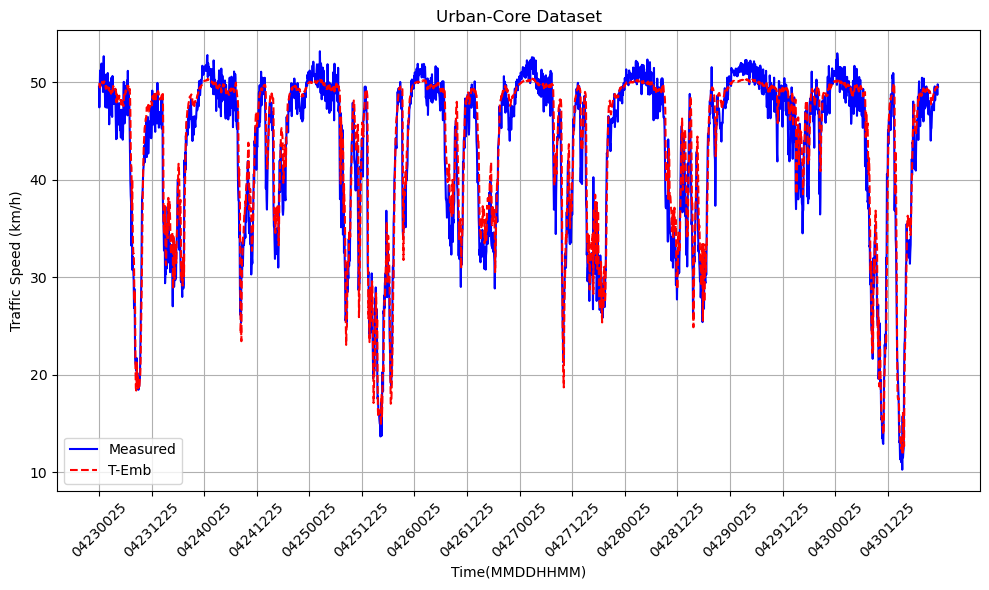

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
node_id = 0
measured = x[node_id,:]      
forecast = pred_x2[node_id,:]      
# forecast = pred_x2[node_id,:]      

plt.figure(figsize=(10, 6))
plt.plot(time, measured, label='Measured', color='blue')
plt.plot(time, forecast, label='T-Emb', color='red', linestyle='--')
# plt.plot(time, forecast, label='T-Only', color='red', linestyle='--')
plt.xticks(np.arange(0,len(time),144))
plt.xticks(rotation=45)

plt.xlabel('Time(MMDDHHMM)')
plt.ylabel('Traffic Speed (km/h)')
plt.title('Urban-Core Dataset')
# plt.title('Urban-Mix Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


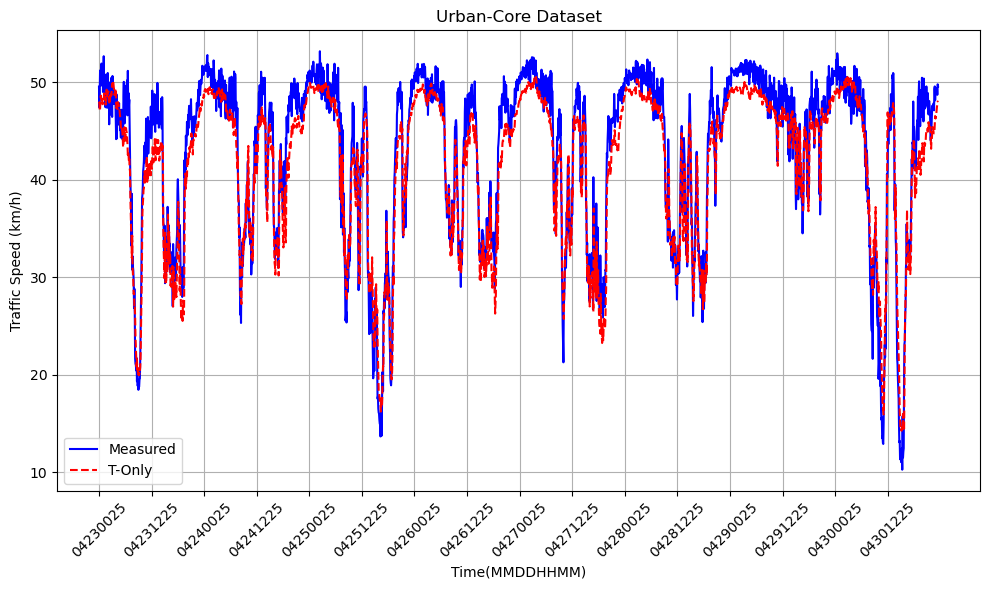

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
node_id = 0
measured = x[node_id,:]      
# forecast = pred_x1[node_id,:]      
forecast = pred_x1[node_id,:]      

plt.figure(figsize=(10, 6))
plt.plot(time, measured, label='Measured', color='blue')
# plt.plot(time, forecast2, label='T-Only', color='red', linestyle='--')
plt.plot(time, forecast, label='T-Only', color='red', linestyle='--')
plt.xticks(np.arange(0,len(time),144))
plt.xticks(rotation=45)

plt.xlabel('Time(MMDDHHMM)')
plt.ylabel('Traffic Speed (km/h)')
plt.title('Urban-Core Dataset')
# plt.title('Urban-Mix Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
